Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 3, 100,  0           []                               
                                 1)]                                                              
                                                                                                  
 time_distributed_6 (TimeDistri  (None, 20, 3, 100,   320        ['input_3[0][0]']                
 buted)                         32)                                                               
                                                                                                  
 time_distributed_7 (TimeDistri  (None, 20, 1, 50, 3  0          ['time_distributed_6[0][0]']     
 buted)                         2)                                                          

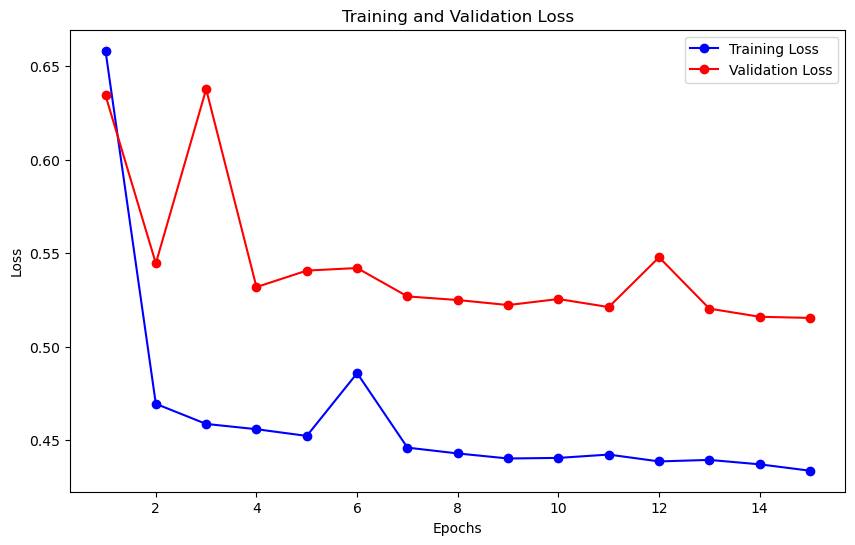

32/32 [==============================] - 0s 9ms/step


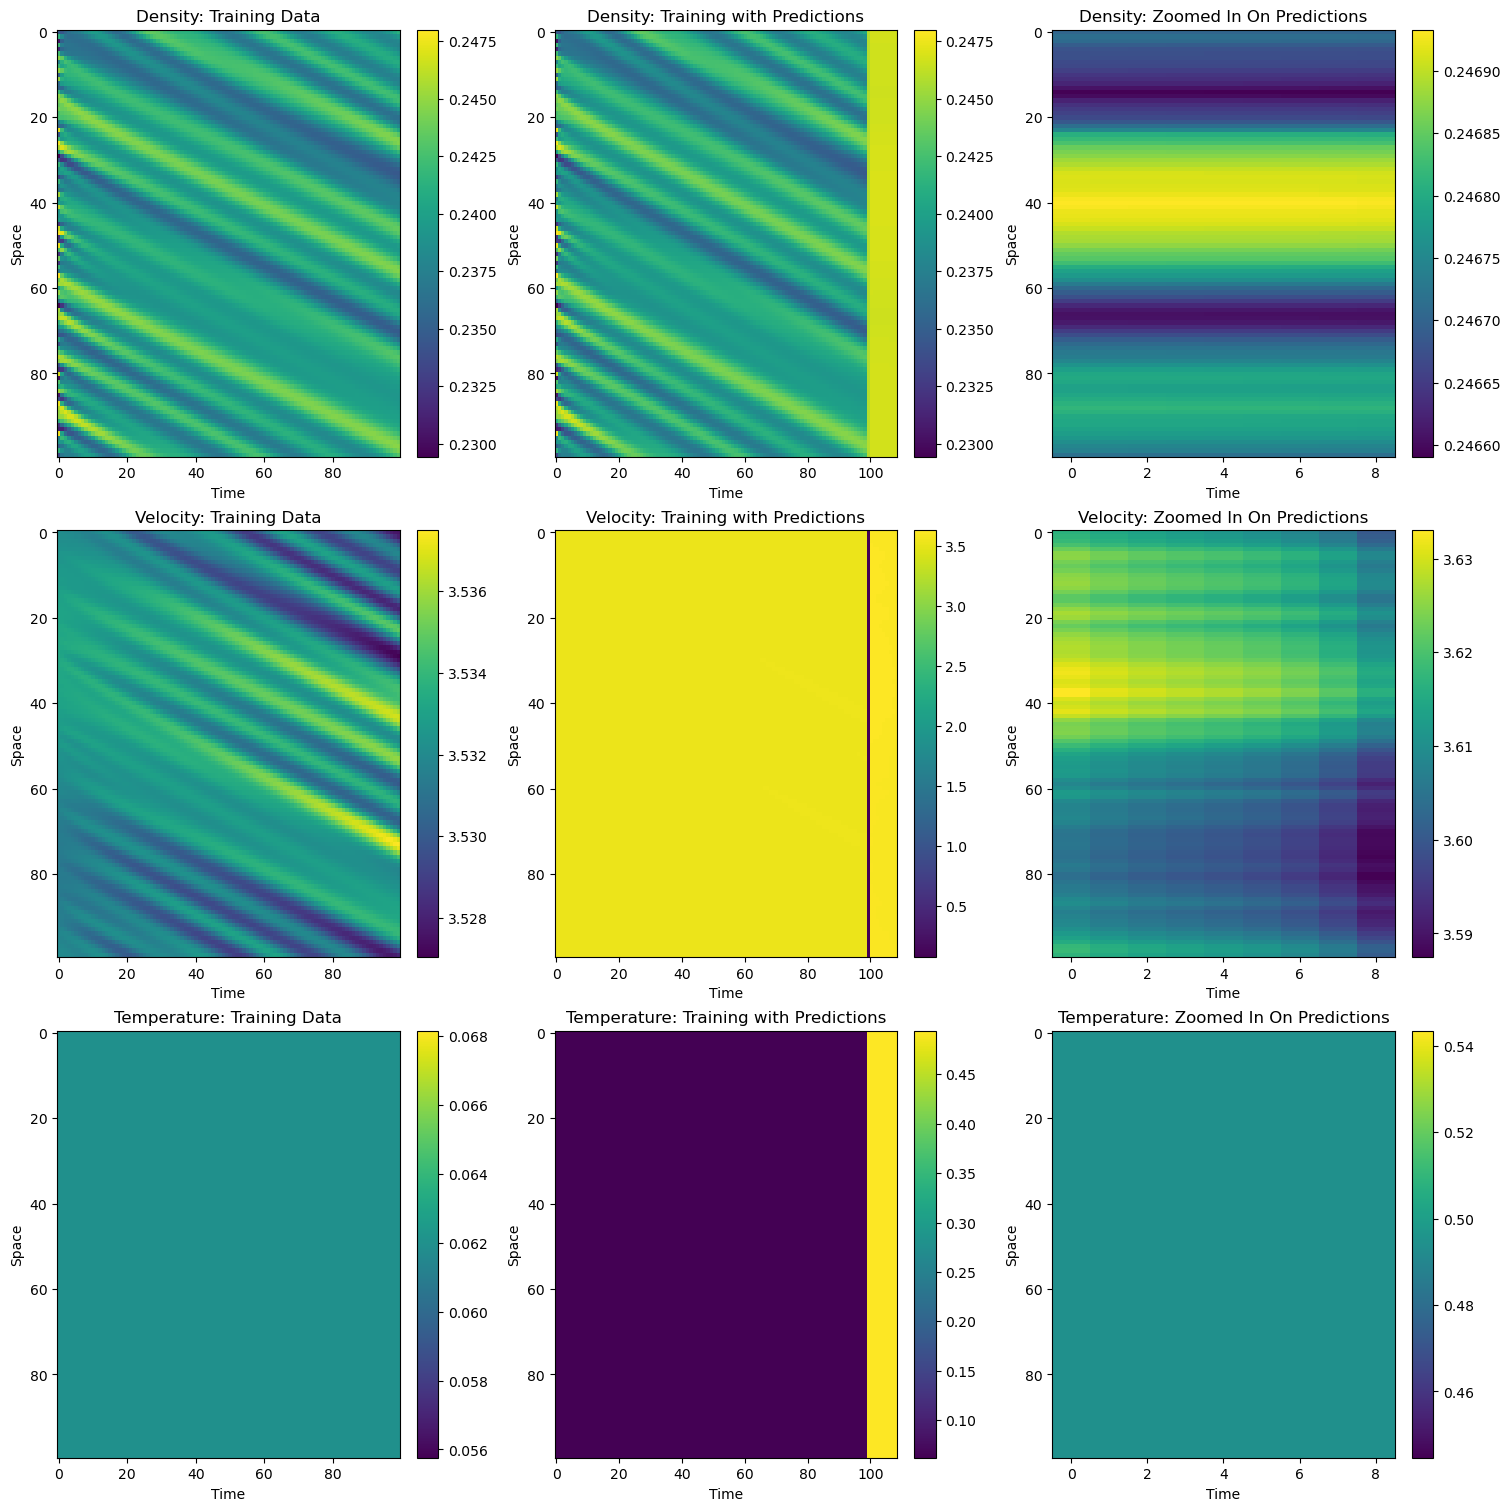

In [4]:
#######################################################
### Physics Informed Hydrodynamics Predictive Model ###
#######################################################

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
from keras.regularizers import l2, l1

###############
## Load Data ##
###############

# Load and preprocess the data
original_data = np.load('Run Information/simulation_data.npz')['data']
num_instances, num_fields, num_snapshots, num_points = original_data.shape
# num_instances = 1000      # Number of instances in the dataset
# num_fields = 3            # Number of fields in the dataset: Density, Velocity, Temperature
# num_snapshots = 100       # Number of snapshots in the dataset
# num_points = 100          # Number of grid points in the dataset

past_steps = 20                 # Number of time steps to consider for the past
num_predicted_snapshots = 1     # Number of time steps for the model to predict
num_train_snapshots = num_snapshots - num_predicted_snapshots  # Number of snapshots to use for training

# Transpose the data to format suitable for CNN and LSTM processing
input_data = np.transpose(original_data, (0, 2, 1, 3))  # Format: (num_instances, num_snapshots, num_fields, num_points)
train_data = input_data[:, :num_train_snapshots, :, :]
target_data = input_data[:, num_train_snapshots:, :, :]

# Normalize the data
# Normalized with respect to each field since the hydrodynamic theory is perturbatively derived off equilibrium theory
mean = np.mean(train_data, axis=(0, 1, 3), keepdims=True)
std = np.std(train_data, axis=(0, 1, 3), keepdims=True)
train_data_normalized = (train_data - mean) / std
target_data_normalized = (target_data - mean) / std

# Function to create training and testing datasets - Based off of ICA_13
def create_dataset(dataset, past_steps, num_predicted_snapshots, is_train=True):
    num_instances, num_snapshots, num_fields, num_points = dataset.shape
    num_features = num_fields * num_points
    dataX, dataY = [], []

    if is_train:
        for instance in range(num_instances):
            for start in range(num_snapshots - past_steps - num_predicted_snapshots + 1):
                end = start + past_steps
                seq_x = dataset[instance, start:end, :, :].reshape(past_steps, num_fields, num_points, 1)
                seq_y = dataset[instance, end:end + num_predicted_snapshots, :, :].reshape(num_predicted_snapshots, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)
    else:
        for instance in range(num_instances):
            # Ensure there are enough snapshots to form a sequence for test data
            if num_snapshots >= past_steps:
                seq_x = dataset[instance, -past_steps:, :, :].reshape(1, past_steps, num_fields, num_points, 1)
                seq_y = target_data[instance, 0, :, :].flatten().reshape(1, num_features)
                dataX.append(seq_x)
                dataY.append(seq_y)

    # Separate output fields for separate physics constraints
    return np.array(dataX).reshape(-1, past_steps, num_fields, num_points, 1), np.array(dataY).reshape(-1, num_points, num_fields)

# Split the data into training and testing sets with correct structure
trainX, trainY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=True)
testX, testY = create_dataset(train_data_normalized, past_steps, num_predicted_snapshots, is_train=False)

####################
### Create Model ###
####################

# Model Hyperparameters - found by tuning in `experiment_architecture.ipynb``
conv_filters = 32
conv_l2 = 0.001
lstm_units_1 = 128
lstm_l1 = 0.0002
lstm_units_2 = 32
dense_density_l2 = 0.00025
dense_velocity_l2 = 0.0001
dense_temperature_l2 =0.0002
learning_rate = 0.0006

# Define the model
input_layer = Input(shape=(past_steps, num_fields, num_points, 1))

# Convolutional and LSTM layers
x = TimeDistributed(Conv2D(conv_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(conv_l2)))(input_layer)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l1(lstm_l1))(x)
x = LSTM(lstm_units_2, kernel_regularizer=l1(lstm_l1))(x)

# Separate outputs for each field with specific activation functions
output_density = Dense(num_points, activation='sigmoid', kernel_regularizer=l2(dense_density_l2))(x)        # Density between 0 and 1
output_velocity = Dense(num_points, kernel_regularizer=l2(dense_velocity_l2))(x)
output_temperature = Dense(num_points, activation='relu', kernel_regularizer=l2(dense_temperature_l2))(x)   # Temperature >= 0

# Combine outputs into a single tensor assuming the same order as in trainY_reshaped
outputs = tf.keras.layers.Concatenate(axis=-1)([output_density, output_velocity, output_temperature])
outputs = Reshape((num_points, num_fields))(outputs)  # Reshape to match the new trainY shape

#######################################
### Specify Model Callbacks and Run ###
#######################################

# Define the ReduceLROnPlateau callback - Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Early Stopping - Prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# ModelCheckpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    'model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# CSVLogger to log training data
csv_logger = CSVLogger('training_log.csv', append=False)

# Compile the model
model = Model(inputs=input_layer, outputs=outputs)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae']
)

# Print model summary
model.summary()

# Train the model with callbacks
history = model.fit(
    trainX, 
    trainY, 
    epochs=15,  # Only use 15 epochs since 5-10 has been enough throuhghout preliminary trainings 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping, model_checkpoint, csv_logger]
)

# Model evaluation
test_loss, test_mae = model.evaluate(testX, testY)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

# Generate predictions for the test dataset
test_predictions = model.predict(testX)

#######################
## Visualize History ##
#######################

# Assuming `history` is your model's training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)  # Assuming epochs start at 1

# Create a line plot of training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#####################################
### Forecast Using One Step Ahead ###
#####################################

# One Step Ahead - Based off of ICA_15
def forecast_snapshots(model, initial_data, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points):
    # Initialize output_data to include training snapshots and space for future predictions
    output_data = np.zeros((num_instances, num_train_snapshots + future_snapshots, num_fields, num_points))
    
    # Copy the training data into the output_data array
    output_data[:, :num_train_snapshots, :, :] = initial_data

    # Use the last 'past_steps' snapshots to predict the next snapshot
    for i in range(future_snapshots):
        # Using the last 'past_steps' snapshots as input for the model
        new_input = output_data[:, num_train_snapshots + i - past_steps:num_train_snapshots + i, :, :]
        new_input_reshaped = new_input.reshape(num_instances, past_steps, num_fields * num_points)
        next_snapshot = model.predict(new_input_reshaped)
        next_snapshot_reshaped = next_snapshot.reshape(num_instances, num_fields, num_points)
        
        # Inserting the predicted snapshot into the next position in the output_data array
        if num_train_snapshots + i < output_data.shape[1] - 1:
            output_data[:, num_train_snapshots + i + 1, :, :] = next_snapshot_reshaped

    return output_data

# Numer of snapshots to forecast
future_snapshots = 10

# Forecast and denormalize
forecasted_data_normalized = forecast_snapshots(model, train_data_normalized, future_snapshots, num_instances, num_fields, num_train_snapshots, num_points)
forecasted_data = forecasted_data_normalized * std + mean

# Transpose forecasted_data to match the dimension order of original_data
forecasted_data = np.transpose(forecasted_data, (0, 2, 1, 3))  # Shape: (num_instances, num_fields, num_train_snapshots + future_snapshots, num_points)

###################################
### Visualize Model Predictions ###
###################################

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
fields = ['Density', 'Velocity', 'Temperature']
instance_idx = 123

for i, field in enumerate(fields):
    # Plot actual data
    ax = axes[i, 0]
    cax = ax.imshow(original_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot data with predictions
    ax = axes[i, 1]
    cax = ax.imshow(forecasted_data[instance_idx, i, :, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Training with Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

    # Plot only predicted data
    ax = axes[i, 2]
    cax = ax.imshow(forecasted_data[instance_idx, i, num_snapshots:, :].T, aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'{field}: Zoomed In On Predictions')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.show()